# Required Imports

- Flags: [True, True, False, False, False]
- Masks: [False, False, True, True, True ]
- Lengths: Just how many real values

In [1]:
import numpy as np
import pickle
import sys
import random
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchmetrics.functional as FM
import seaborn as sns
from tqdm import tqdm
sys.path.append('DG/gan')
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
%matplotlib inline
import gc
matplotlib.style.use('classic')

from sklearn.metrics import precision_recall_fscore_support as score
# pl.utilities.seed.seed_everything(seed=2) # sets seed for pseudo-random number generators in: pytorch, numpy, python.random

In [2]:
# In real data, if flag sum is 1 --> Then no timestep at all. --> So we do remove those ones by converting them to zeros, then remove from the list
# In real data, there is no flag of length ZERO
def remove_zero_datapoints(X,Y,flag):
    indices_non_zero = torch.nonzero(torch.sum(flag,1)-1).squeeze()
    return X[indices_non_zero], Y[indices_non_zero], flag[indices_non_zero]

def get_one_class(X,Y ,flag,class_label): # (X, Y, and flag) are the whole dataset that is consisted of many classes, Y is NOT One-Hot Encoded
    indices_class_label = np.where(Y==class_label)
    return X[indices_class_label], Y[indices_class_label],flag[indices_class_label]

def get_n_samples(X,Y,flag,n_samples):
    randomList = random.sample(range(0, Y.shape[0]), n_samples)
    return X[randomList], Y[randomList], flag[randomList]

In [3]:
train_real = np.load('data/google/data_train_reduced.npz')

real_train_X =  torch.from_numpy(train_real['data_feature']).float()
real_train_Y =  torch.from_numpy(train_real['data_attribute']).float()
real_train_Y_labels = torch.argmax(real_train_Y,1)
real_train_flags = torch.from_numpy(train_real['data_gen_flag']) 

real_train_X, real_train_Y_labels, real_train_flags = remove_zero_datapoints(real_train_X, real_train_Y_labels, real_train_flags)

real_train_lengths = torch.sum(real_train_flags,1)

real_train_X0,real_train_Y0,real_train_flag0 = get_one_class(real_train_X, real_train_Y_labels,real_train_flags,0)
real_train_X1,real_train_Y1,real_train_flag1 = get_one_class(real_train_X, real_train_Y_labels,real_train_flags,1)
real_train_X2,real_train_Y2,real_train_flag2 = get_one_class(real_train_X, real_train_Y_labels,real_train_flags,2)
real_train_X3,real_train_Y3,real_train_flag3 = get_one_class(real_train_X, real_train_Y_labels,real_train_flags,3)

In [4]:
real_train_X0.shape

torch.Size([3125, 2500, 9])

In [5]:
test_real = np.load('data/google/data_test_reduced.npz')

real_test_X =  torch.from_numpy(test_real['data_feature']).float()
real_test_Y =  torch.from_numpy(test_real['data_attribute']).float()
real_test_Y_labels = torch.argmax(real_test_Y,1)
real_test_flags = torch.from_numpy(test_real['data_gen_flag']) 

real_test_X, real_test_Y_labels,real_test_flags = remove_zero_datapoints(real_test_X, real_test_Y_labels,real_test_flags)

real_test_lengths = torch.sum(real_test_flags,1)

real_test_X0,real_test_Y0,real_test_flag0 = get_one_class(real_test_X, real_test_Y_labels,real_test_flags,0)
real_test_X1,real_test_Y1,real_test_flag1 = get_one_class(real_test_X, real_test_Y_labels,real_test_flags,1)
real_test_X2,real_test_Y2,real_test_flag2 = get_one_class(real_test_X, real_test_Y_labels,real_test_flags,2)
real_test_X3,real_test_Y3,real_test_flag3 = get_one_class(real_test_X, real_test_Y_labels,real_test_flags,3)

# Generated Data

In [6]:
#-------------------------------------------------------------------------DG Data-----------------------------------------------------------#
DG = np.load('data_generated/google/generated_data_train.npz')

DG_X =  torch.from_numpy(DG['data_feature']).float()
DG_Y =  torch.from_numpy(DG['data_attribute']).float()
DG_Y_labels = torch.argmax(DG_Y,1)
DG_flags =  torch.from_numpy(DG['data_gen_flag'] )

DG_X, DG_Y_labels,DG_flags = remove_zero_datapoints(DG_X, DG_Y_labels,DG_flags)

DG_lengths =torch.sum(DG_flags,1)

DG_X0, DG_Y_labels0,DG_flag0 = get_one_class(DG_X, DG_Y_labels,DG_flags,0)
DG_X1, DG_Y_labels1,DG_flag1 = get_one_class(DG_X, DG_Y_labels,DG_flags,1)
DG_X2, DG_Y_labels2,DG_flag2 = get_one_class(DG_X, DG_Y_labels,DG_flags,2)
DG_X3, DG_Y_labels3,DG_flag3 = get_one_class(DG_X, DG_Y_labels,DG_flags,3)

In [7]:
#-------------------------------------------------------------------------DG Data-----------------------------------------------------------#
DG = np.load('data_generated/google/generated_data_test.npz')

DG_X =  torch.from_numpy(DG['data_feature']).float()
DG_Y =  torch.from_numpy(DG['data_attribute']).float()
DG_Y_labels = torch.argmax(DG_Y,1)
DG_flags =  torch.from_numpy(DG['data_gen_flag'] )

DG_X, DG_Y_labels,DG_flags = remove_zero_datapoints(DG_X, DG_Y_labels,DG_flags)

DG_lengths =torch.sum(DG_flags,1)

DG_X0, DG_Y_labels0,DG_flag0 = get_one_class(DG_X, DG_Y_labels,DG_flags,0)
DG_X1, DG_Y_labels1,DG_flag1 = get_one_class(DG_X, DG_Y_labels,DG_flags,1)
DG_X2, DG_Y_labels2,DG_flag2 = get_one_class(DG_X, DG_Y_labels,DG_flags,2)
DG_X3, DG_Y_labels3,DG_flag3 = get_one_class(DG_X, DG_Y_labels,DG_flags,3)

In [8]:
len(DG_X0),len(real_train_X0)

(6150, 3125)

In [9]:
# TST_all = np.load('Flags1/npz_transformer_flags1_V11.1.npz')
# TST_all = np.load('Sigmoid/npz_transformer_Sig_V6.npz')
# TST_all = np.load('Token/npz_transformer_token_V11.1.npz')
TST_all = np.load('npz_transformer_allV3_new.npz')

TST_train_X,TST_train_Y_labels, TST_train_mask =  torch.tensor(TST_all['X']).float(), torch.tensor(TST_all['Y']).float(),torch.Tensor(TST_all['masks']).float()


TST_X0, TST_Y_labels0,TST_mask0 = get_one_class(TST_train_X,TST_train_Y_labels, TST_train_mask,0)
TST_X1, TST_Y_labels1,TST_mask1 = get_one_class(TST_train_X,TST_train_Y_labels, TST_train_mask,1)
TST_X2, TST_Y_labels2,TST_mask2 = get_one_class(TST_train_X,TST_train_Y_labels, TST_train_mask,2)
TST_X3, TST_Y_labels3,TST_mask3 = get_one_class(TST_train_X,TST_train_Y_labels, TST_train_mask,3)

In [10]:
# TST_all_X = TST_all_X[...,:-1]
TST_train_X.shape

torch.Size([24462, 400, 9])

In [11]:
TST_X0.shape,real_train_X0.shape

(torch.Size([3125, 400, 9]), torch.Size([3125, 2500, 9]))

# Predictor

In [12]:
percent = int(len(real_train_X)*0.05)
len(real_train_Y_labels[:percent])

1223

In [13]:
class MLPModel(pl.LightningModule):
    def __init__(self,n_features=9,n_timesteps=400,n_hidden=128,n_output=4):
        super().__init__()
        # need to be (self) in order to be optimized and part of model
        self.model = nn.Sequential(
                  nn.Flatten(start_dim=1),
                  nn.Linear(n_features*n_timesteps,n_hidden),
                  nn.ReLU(),
                  nn.Linear(n_hidden,n_output),
                )
    def forward(self,x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y) #y_hat is (N, C) and y is (N)
        acc = FM.accuracy(F.softmax(y_hat,1), y)
        self.log('accuracy',acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss,'acc':acc}
    
    def test_step(self,batch,batch_idx):
        x, y = batch # y_real is labels (sk)
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y) #y_hat is (N, C) and y is (N)
        acc = FM.accuracy(F.softmax(y_hat,1), y)
        self.log('accuracy',acc, on_epoch=True,prog_bar=True, logger=True)
        return {'loss': loss}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [16]:
params = {'shuffle': True,'num_workers': 0,'batch_size':256}

if __name__ == '__main__':
#     dataset = torch.utils.data.TensorDataset(real_train_X[:,:400,:9].to(device),real_train_Y_labels.long().to(device))

    dataset = torch.utils.data.TensorDataset(TST_train_X[:,:400,:9].to(device),TST_train_Y_labels.long().to(device))
#     dataset = torch.utils.data.TensorDataset(torch.cat((TST_all_X[:,:400,:9].to(device),real_train_X[:percent,:400].to(device))),
#                                              torch.cat((TST_all_Y_labels.long().to(device),real_train_Y_labels[:percent].to(device))))

    train_dataloader  = torch.utils.data.DataLoader(dataset, **params)
    dataset =  torch.utils.data.TensorDataset(real_test_X[:,:400].to(device),real_test_Y_labels.to(device))

    test_dataloader  = torch.utils.data.DataLoader(dataset)
    model = MLPModel()

trainer = pl.Trainer(gpus='1',max_epochs=100,progress_bar_refresh_rate=1)
trainer.fit(model,train_dataloader)
trainer.test(test_dataloaders=test_dataloader) # No need to repass (model), It will by itself work from test_step
print("DONE")
# "class_all_generatedV2" alone gives 0.732

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 461 K 
-------------------------------------
461 K     Trainable params
0         Non-trainable params
461 K     Total params
1.846     Total estimated model params size (MB)
/rhome/yelnady/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/rhome/yelnady/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.7297075986862183}
--------------------------------------------------------------------------------
DONE


In [ ]:
# The "model" has been trained just by passing it into the trainer, we can now use it directly.
predictions = F.softmax(model(TST_train_X[:,:400,:9].to("cuda:0")),1) # The gpu is chosen by PL
predictions = np.argmax(predictions.cpu().detach().numpy(),1)
_, _, fscore, _ = score(TST_train_Y_labels, predictions)
print('fscore: {}'.format(fscore))

# Using the magic row I got 0.736, with all data we got 0.8119, using 1% I got 0.7498, 2% we have 0.7613, 5% we have 

# Discriminator/Classifier

In [15]:
class Discriminator(pl.LightningModule):
    def __init__(self,n_features=9,n_timesteps=400,n_hidden=128,n_output=1):
        super().__init__()
        # need to be (self) in order to be optimized and part of model
        self.model = nn.Sequential(
                  nn.Flatten(start_dim=1),
                  nn.Linear(n_features*n_timesteps,n_hidden),
                  nn.ReLU(),
                  nn.Linear(n_hidden,n_output),
                )
    def forward(self,x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat,y) #y_hat is (N,) and y is (N,) - same shape
        acc = FM.accuracy(F.sigmoid(y_hat), y.long()) # Sigmoid is same as Softmax when Binary Classification
        self.log('accuracy',acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss,'acc':acc}
    
    def test_step(self,batch,batch_idx):
        x, y = batch # y_real is labels (sk)
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)  #y_hat is (N,) and y is (N,) - same shape
        acc = FM.accuracy(F.sigmoid(y_hat), y)
        self.log('accuracy',acc, on_epoch=True,prog_bar=True, logger=True)
        return {'loss': loss}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [16]:
params = {'shuffle': True,'num_workers': 0,'batch_size':256}

real_train_X = real_train_X[:,:400,:9] ; real_train_Y = torch.ones([real_train_X.shape[0], 1], dtype=torch.float32)
TST_train_X =  TST_train_X[:,:400,:9]  ; TST_train_Y = torch.zeros([TST_train_X.shape[0], 1], dtype=torch.float32)
train_disc_X = torch.cat((real_train_X,TST_train_X)) ; train_disc_Y = torch.cat((real_train_Y,TST_train_Y))

real_test_X = real_test_X[:,:400,:9] ; real_test_Y = torch.ones([real_test_X.shape[0], 1], dtype=torch.float32)

if __name__ == '__main__':

    dataset = torch.utils.data.TensorDataset(train_disc_X.to(device),train_disc_Y.to(device))
    train_dataloader  = torch.utils.data.DataLoader(dataset, **params)
#     dataset =  torch.utils.data.TensorDataset(real_test_X[:,:400].to(device),real_test_Y_labels.to(device))
#     test_dataloader  = torch.utils.data.DataLoader(dataset)
    
    model = Discriminator()

trainer = pl.Trainer(gpus=1,max_epochs=100,progress_bar_refresh_rate=1)
trainer.fit(model,train_dataloader)
trainer.test(test_dataloaders=test_dataloader) # No need to repass (model), It will by itself work from test_step
print("DONE")


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 461 K 
-------------------------------------
461 K     Trainable params
0         Non-trainable params
461 K     Total params
1.844     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/rhome/yelnady/.local/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: 

# Plotting Algorithms Performance

/rhome/yelnady/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_anchor" which is no longer supported as of 3.3 and will become an error two minor releases later


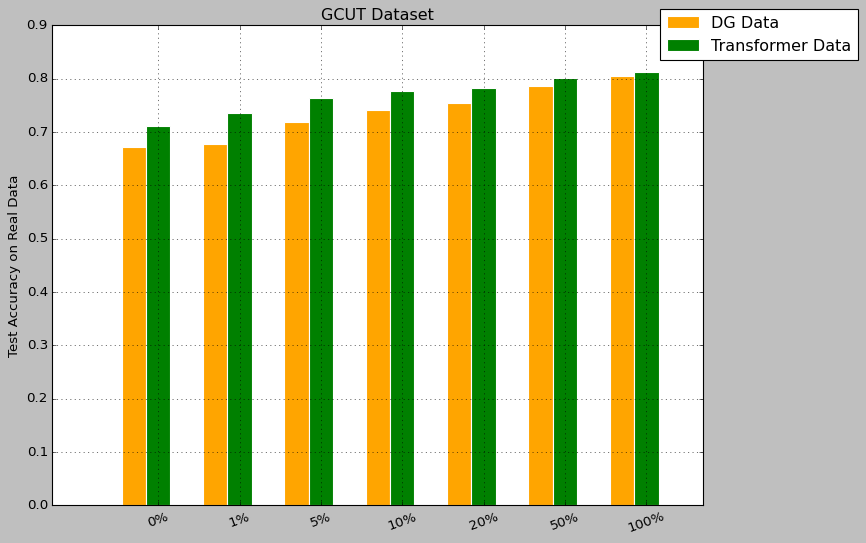

In [11]:

import numpy as np


labels = ['0%','1%','5%','10%','20%','50%','100%']
DG = [ 0.671,0.677,0.719 ,   0.741,0.755, 0.786, 0.804 ]
TST = [0.711,0.736, 0.764, 0.776 , 0.782, 0.802,0.8123]
x = np.arange(len(labels))  # the label locations
barWidth = 0.30  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(10.5, 7.5)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Test Accuracy on Real Data')
ax.set_title('GCUT Dataset')

# Set position of bar on X axis
r1 = np.arange(len(TST))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, DG, color='orange', width=barWidth, edgecolor='white', label='DG Data')
plt.bar(r2, TST, color='green', width=barWidth, edgecolor='white', label='Transformer Data')

# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(TST))], labels,rotation=20)
plt.grid()
# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1.25, 1.05))
plt.savefig('GCUT_Dataset.png',facecolor='white',dpi=160,bbox_to_anchor=(1.25, 1.05), bbox_inches='tight')
plt.show()


# CDFs- Sequence Lengths

(0.0, 50.0)

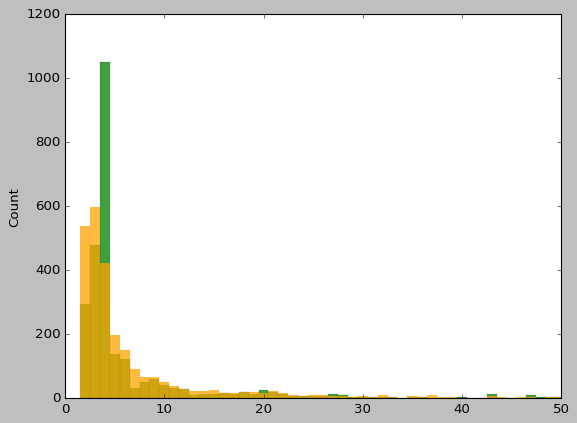

In [21]:
sns.histplot(TST_class3_lengths, discrete=True,color='green' )
sns.histplot(real_class3_lengths, discrete=True,color='orange' )

plt.xlim([0,50])
# plt.ylim([0,900])

(0.0, 50.0)

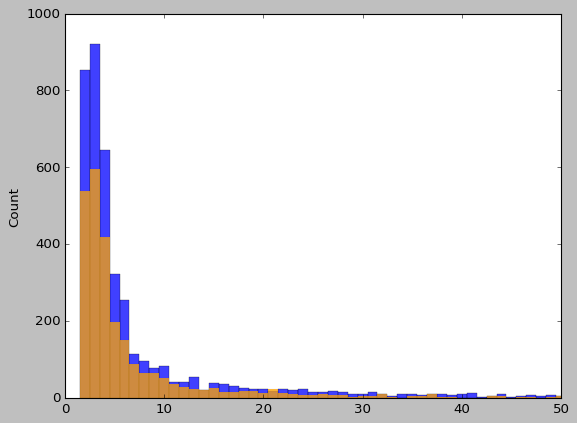

In [22]:
sns.histplot(DG_class3_lengths, discrete=True,color='blue' )
sns.histplot(real_class3_lengths, discrete=True,color='orange' )

plt.xlim([0,50])
# plt.ylim([0,900])

Real Data Average Sequence Length 30.27115445108525
DG Data Average Sequence Length: 27.394958


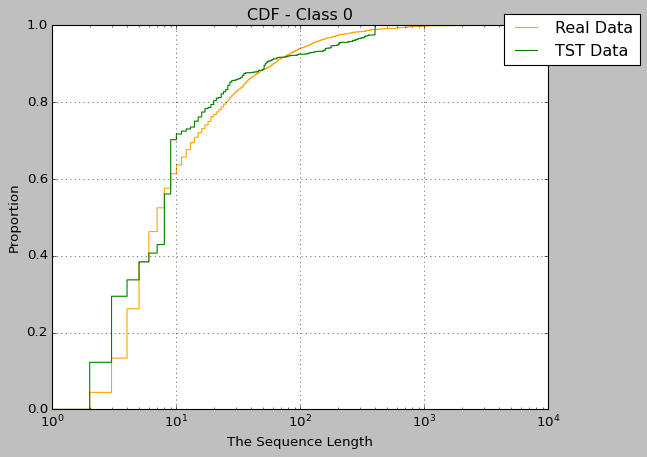

In [20]:
real_class0_lengths= torch.sum(real_test_flag0,1).numpy()
TST_class0_lengths= torch.sum((TST_mask0==0).squeeze().long(),1).numpy()
DG_class0_lengths= torch.sum(DG_flag0,1).numpy()

print("Real Data Average Sequence Length",np.mean(real_class0_lengths).item())
print("DG Data Average Sequence Length:",np.mean(DG_class0_lengths))
# print("TST Data Average Sequence Length:",np.mean(TST_class0_lengths))
fig, ax = plt.subplots()

plt.grid()

sns.ecdfplot(data=real_class0_lengths,legend=True,label='Real Data',color='orange')
# sns.ecdfplot(data=DG_class0_lengths,legend=True,label='DG Data',color='blue')
sns.ecdfplot(data=TST_class0_lengths,legend=True,label='TST Data',color='green')
plt.xscale("log")
ax.set_title('CDF - Class 0')
ax.set_xlabel('The Sequence Length')
leg = ax.legend(bbox_to_anchor=(1.2, 1.05))

Real Data Average Sequence Length 5.940918213748119
DG Data Average Sequence Length: 6.506379
TST Data Average Sequence Length: 5.9285


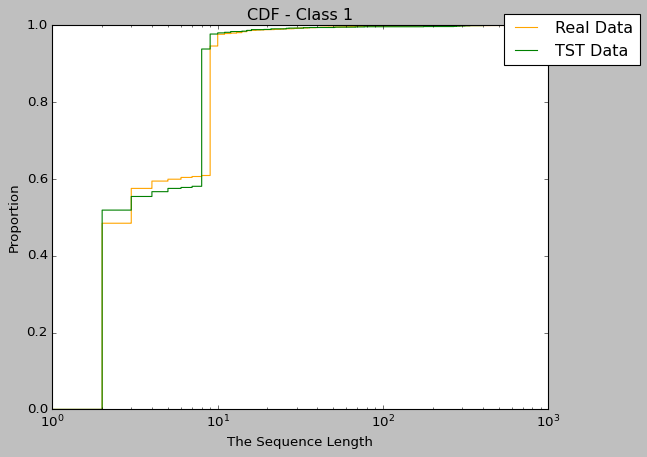

In [23]:
real_class1_lengths= torch.sum(real_test_flag1,1).numpy()
DG_class1_lengths= torch.sum(DG_flag1,1).numpy()
TST_class1_lengths= torch.sum((TST_mask1==0).squeeze().long(),1).numpy()

print("Real Data Average Sequence Length",np.mean(real_class1_lengths).item())
print("DG Data Average Sequence Length:",np.mean(DG_class1_lengths))
print("TST Data Average Sequence Length:",np.mean(TST_class1_lengths))
fig, ax = plt.subplots()



sns.ecdfplot(data=real_class1_lengths,legend=True,label='Real Data',color='orange')
# sns.ecdfplot(data=DG_class1_lengths,legend=True,label='DG Data',color='blue')
sns.ecdfplot(data=TST_class1_lengths,legend=True,label='TST Data',color='green')

plt.xscale("log")
ax.set_title('CDF - Class 1')
ax.set_xlabel('The Sequence Length')
leg = ax.legend(bbox_to_anchor=(1.2, 1.05))

Real Data Average Sequence Length 8.941049266641594
DG Data Average Sequence Length: 10.113139
TST Data Average Sequence Length: 12.99332455810455


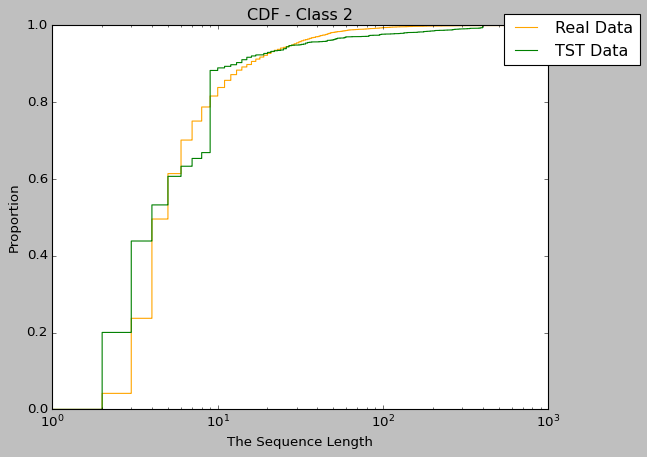

In [14]:
real_class2_lengths= torch.sum(real_train_flag2,1).numpy()
TST_class2_lengths= torch.sum((TST_mask2==0).squeeze().long(),1).numpy()
DG_class2_lengths= torch.sum(DG_flag2,1).numpy()

print("Real Data Average Sequence Length",np.mean(real_class2_lengths).item())
print("DG Data Average Sequence Length:",np.mean(DG_class2_lengths))
print("TST Data Average Sequence Length:",np.mean(TST_class2_lengths))
fig, ax = plt.subplots()



sns.ecdfplot(data=real_class2_lengths,legend=True,label='Real Data',color='orange')
# sns.ecdfplot(data=DG_class2_lengths,legend=True,label='DG Data',color='blue')
sns.ecdfplot(data=TST_class2_lengths,legend=True,label='TST Data',color='green')

plt.xscale("log")
ax.set_title('CDF - Class 2')
ax.set_xlabel('The Sequence Length')
leg = ax.legend(bbox_to_anchor=(1.2, 1.05))

Real Data Average Sequence Length 20.143236074270558
DG Data Average Sequence Length: 8.398931
TST Data Average Sequence Length: 12.337


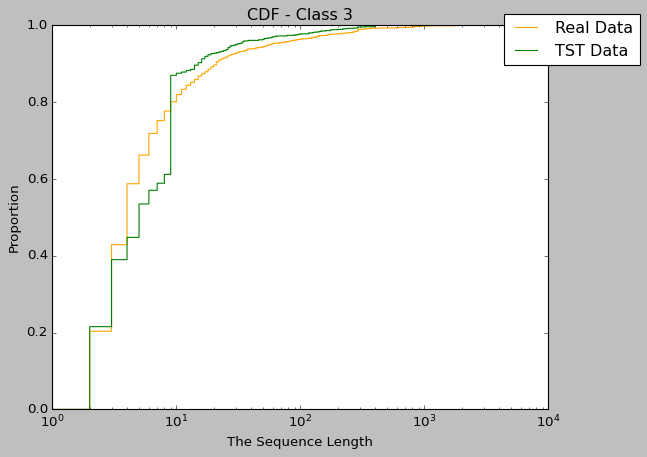

In [10]:
real_class3_lengths= torch.sum(real_train_flag3,1).numpy()
TST_class3_lengths= torch.sum((TST_mask3==0).squeeze().long(),1).numpy()
DG_class3_lengths= torch.sum(DG_flag3,1).numpy()

print("Real Data Average Sequence Length",np.mean(real_class3_lengths).item())
print("DG Data Average Sequence Length:",np.mean(DG_class3_lengths))
print("TST Data Average Sequence Length:",np.mean(TST_class3_lengths))
fig, ax = plt.subplots()



sns.ecdfplot(data=real_class3_lengths,legend=True,label='Real Data',color='orange')
# sns.ecdfplot(data=DG_class3_lengths,legend=True,label='DG Data',color='blue')
sns.ecdfplot(data=TST_class3_lengths,legend=True,label='TST Data',color='green')

plt.xscale("log")
ax.set_title('CDF - Class 3')
ax.set_xlabel('The Sequence Length')
leg = ax.legend(bbox_to_anchor=(1.2, 1.05))

Real Data Average Sequence Length 11.665113236857167
DG Data Average Sequence Length: 10.913229
TST Data Average Sequence Length: 12.977038995928305


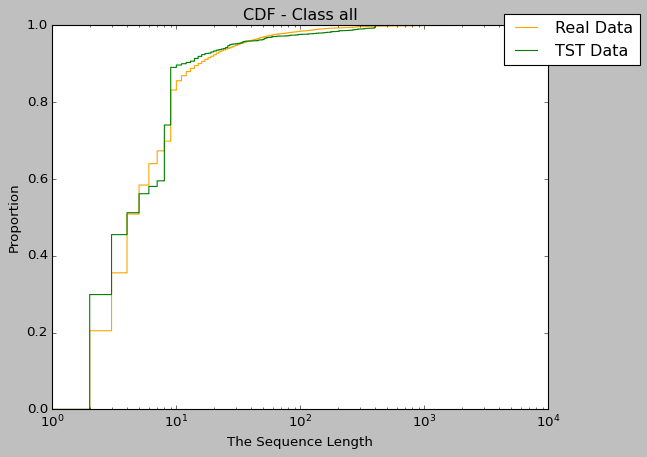

In [11]:
real_class_lengths= torch.sum(real_train_flags,1).numpy()
TST_class_lengths= torch.sum((TST_train_mask==0).squeeze().long(),1).numpy()
DG_class_lengths= torch.sum(DG_flags,1).numpy()

print("Real Data Average Sequence Length",np.mean(real_class_lengths).item())
print("DG Data Average Sequence Length:",np.mean(DG_class_lengths))
print("TST Data Average Sequence Length:",np.mean(TST_class_lengths))
fig, ax = plt.subplots()

sns.ecdfplot(data=real_class_lengths,legend=True,label='Real Data',color='orange')
# sns.ecdfplot(data=DG_class_lengths,legend=True,label='DG Data',color='blue')
sns.ecdfplot(data=TST_class_lengths,legend=True,label='TST Data',color='green')

plt.xscale("log")
ax.set_title('CDF - Class all')
ax.set_xlabel('The Sequence Length')
leg = ax.legend(bbox_to_anchor=(1.2, 1.05))

# Cross-Measurement Correlation

- **CPU_rate**
- canonical_memory_usage
- **assigned_memory_usage**
- unmapped_page_cache
- total_page_cache
- maximum_memory_usage
- local_disk_space_usage
- maximum_CPU_rate
-sampled_CPU_usage

In [12]:
from scipy import stats
import numpy.ma as ma

def get_cross_correlation_masked(X,flags):
    correlations = []
    for datapoint,flag in zip(X,flags):
        a = ma.array(datapoint[...,0], mask = (flag))
        b = ma.array(datapoint[...,2], mask = (flag))
        correlations.append(stats.mstats.pearsonr(a,b)[0])
    return correlations
real_train_correlation = get_cross_correlation_masked(real_train_X,real_train_flags==0)
DG_correlation = get_cross_correlation_masked(DG_X,DG_flags==0)
TST_correlation = get_cross_correlation_masked(TST_train_X,TST_train_mask)

/rhome/yelnady/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


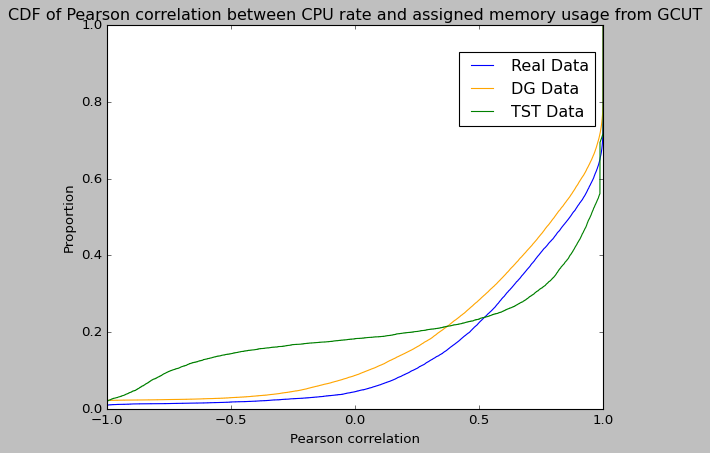

In [13]:
fig, ax = plt.subplots()

sns.ecdfplot(data=real_train_correlation,legend=True,label='Real Data',color='blue')
sns.ecdfplot(data=DG_correlation,legend=True,label='DG Data',color='orange')
sns.ecdfplot(data=TST_correlation,legend=True,label='TST Data',color='green')

ax.set_title('CDF of Pearson correlation between CPU rate and assigned memory usage from GCUT')
ax.set_xlabel('Pearson correlation')

ax.set_xlim([-1, +1])

leg = ax.legend(bbox_to_anchor=(1, 0.95))

# Other ML Models

In [6]:
def other_models(train_X, train_Y_labels,test_X,test_Y_lables):
    naive2 = GaussianNB()
    naive2.fit(train_X, train_Y_labels)
    print('Naive',naive2.score(test_X,test_Y_lables))
    
    lor2 = LogisticRegression()
    lor2.fit(train_X,train_Y_labels)
    print('Logistic Regression',lor2.score(test_X,test_Y_lables)) 
    
    dt2 = DecisionTreeClassifier()
    dt2.fit(train_X, train_Y_labels)
    print('Decision Tree',dt2.score(test_X,test_Y_lables))

    svm2 = LinearSVC()
    svm2.fit(train_X, train_Y_labels)
    print('SVM',svm2.score(test_X,test_Y_lables))

In [22]:
other_models(torch.flatten(real_train_X,1),real_train_Y_labels,torch.flatten(real_test_X,1) , real_test_Y_labels)

Naive 0.43741566141893273


/rhome/yelnady/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Decision Tree 0.7159885503986915
Decision Tree 0.8097526068288694


/rhome/yelnady/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 0.7308116949499079


In [37]:
other_models(torch.flatten(DG_X[:,:400],1),DG_Y_labels,torch.flatten(real_test_X[:,:400],1) , real_test_Y_labels)

Naive 0.11044776119402985


/rhome/yelnady/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression 0.7065426293191577
Decision Tree 0.32983030055203433
SVM 0.6738499284399918


In [9]:
other_models(torch.flatten(TST_all_X[:,:400,:9],1),TST_all_Y_labels,torch.flatten(real_test_X[:,:400,],1) , real_test_Y_labels)

Naive 0.3522388059701492


/rhome/yelnady/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression 0.7031077489265999
Decision Tree 0.3874258842772439


/rhome/yelnady/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


SVM 0.7121447556736864


In [10]:
other_models(torch.flatten(torch.cat((TST_all_X,real_train_X[:,:400])),1),torch.cat((TST_all_Y_labels,real_train_Y_labels))
             ,torch.flatten(real_test_X[:,:400],1) , real_test_Y_labels)

Naive 0.4139439787364547


/rhome/yelnady/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression 0.6824984665712533
Decision Tree 0.7955837252095685


/rhome/yelnady/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


SVM 0.7037620118585156


In [40]:
other_models(torch.flatten(torch.cat((DG_X[:,:400],real_train_X[:,:400])),1),torch.cat((DG_Y_labels,real_train_Y_labels))
             ,torch.flatten(real_test_X[:,:400],1) , real_test_Y_labels)

Naive 0.36736863627070127


/rhome/yelnady/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression 0.7193620936413821
Decision Tree 0.8080556123492129


/rhome/yelnady/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 0.7292782662032304
